In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from pandas.plotting import scatter_matrix


In [0]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

def poly_model(datas,actuals):
  a = PolynomialFeatures(2)
  
  #print(a.fit_transform(datas).astype(int))
  modelo = make_pipeline(a, LinearRegression())
  modelo.fit(datas, actuals)
  
  predicts = modelo.predict(datas)
  return (predicts,modelo)

def plot_model(datas,actuals,predicts):
  fig = pyplot.figure()
  ax = Axes3D(fig)
  #XT = datas.transpose()
  x_vals = datas[0]
  y_vals = datas[1]
  z_vals = actuals
  #print("x_vals",x_vals.shape)
  #print("y_vals",y_vals.shape)
  #print("z_vals",z_vals.shape)
  
  
  ax.scatter(x_vals, y_vals, z_vals, color='red')
  ax.scatter(x_vals, y_vals, predicts, color='blue')
  
  
def f_x12_x21(x):
  #print(x[0],x[1])
  return (x[0]**2+10*x[1] ) * np.random.randint(70,130, size=1)[0] / 100

def gen_data(x,func):
  func_applied = np.apply_along_axis(func, 1, x)
  return func_applied

def calculate_mse(actuals,predicts):
  mse = sum((actuals-predicts)**2) / len(actuals)
  return mse

class TestStats:
  pass

precision = "{0:.8f}"

make0 = lambda x: 0 if x == 0 else x
make0func = np.vectorize(make0)

def linear_regression(data,actuals):
  linreg = LinearRegression(normalize=True)
  linreg.fit(data,actuals)
  y_pred = linreg.predict(data)
  
  stats = TestStats()
  stats.name = "Linear -"
  stats.data = data
  stats.actuals = actuals
  stats.predictions = y_pred
  stats.model = linreg
  stats.coeffs = np.array([ precision.format(  xi ) for xi in linreg.coef_]) 
  stats.intercept = linreg.intercept_
  
  stats.coeffs_zero = np.count_nonzero(linreg.coef_  == 0)
  stats.zero_params =  ', '.join( data.columns[ np.where( linreg.coef_ == 0) ] )
  
  calculate_stats(stats)
  return stats


def ridge_regression(data,actuals,alpha):
   
  
  ridgereg = Ridge(alpha=alpha,normalize=True)
  ridgereg.fit(data, actuals)
  y_pred = ridgereg.predict(data)
  
  stats = TestStats()
  stats.name = "Ridge -"+str(alpha  )
  stats.data = data
  stats.actuals = actuals
  stats.predictions = y_pred
  stats.model = ridgereg
  stats.coeffs = np.array([ precision.format(  xi ) for xi in ridgereg.coef_]) 
  stats.intercept = ridgereg.intercept_
  
  stats.coeffs_zero = np.count_nonzero(ridgereg.coef_  == 0)
  stats.zero_params = ', '.join( data.columns[ np.where( ridgereg.coef_ == 0) ] )

  
  calculate_stats(stats)
  return stats


def lasso_regression(data,actuals,alpha,fit_intercept ):
  
  
  
  lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5,fit_intercept=fit_intercept)
  lassoreg.fit(data,actuals)
  y_pred = lassoreg.predict(data)
  
  stats = TestStats()
  stats.name = "Lasso -"+str(alpha) +"|"+str( fit_intercept)
  stats.data = data
  stats.actuals = actuals
  stats.predictions = y_pred
  stats.model = lassoreg
  stats.coeffs =  make0func( np.array([ precision.format(  xi ) for xi in lassoreg.coef_]) )
  stats.intercept = lassoreg.intercept_
  
  stats.coeffs_zero = np.count_nonzero(lassoreg.coef_  == 0)
  stats.zero_params = ', '.join( data.columns[ np.where( lassoreg.coef_ == 0) ] )
  
  calculate_stats(stats)
  return stats


    

def calculate_stats(stats):
  stats.mse = precision.format( calculate_mse(stats.actuals,stats.predictions) )
  stats.r2_score = r2_score(stats.actuals,stats.predictions)
  stats.mean_squared_error = precision.format( mean_squared_error(stats.actuals,stats.predictions))
  
  
  
def dump_stats(stats): 
  print("r2_score",stats.r2_score)
  print("mean_squared_error",stats.mean_squared_error)  
  print("coeffs",stats.coeffs)  
  print("mse", stats.mse)
  
  
def plot_from_stats(stats):
  plot_model(stats.data.transpose(),stats.actuals.transpose(),stats.predictions)
  
  

def append_df(df,stat_instances,col_name):
  vals = []  
  for stat in stat_instances:  
    vals.append(getattr(stat, col_name))
  df[col_name] = vals  
  
def get_attributes(stats,field):
  vals = []
  for stat in stats:
    vals.append(getattr(stat, field))
  return vals  

def get_multi_attributes(stats,field,index):
  vals = []
  for stat in stats:
    vals.append(getattr(stat, field)[index])
  return vals    

In [0]:
def test_batch(dataset):
  alphas = [ 1e-10,  1e-4, 1e-3,1e-2, 1, 5]
  parameter_columns = dataset.columns.drop("y")
  data = dataset[parameter_columns]
  
  actuals = dataset['y']
  stats = []
  for alpha in alphas :
    stats_lasso = lasso_regression(data,actuals,alpha,False) 
    stats.append(stats_lasso)
  
  for alpha in alphas :
    stats_lasso = lasso_regression(data,actuals,alpha,True) 
    stats.append(stats_lasso)  

  for alpha in alphas :
    stats_ridge = ridge_regression(data,actuals,alpha) 
    stats.append(stats_ridge)
  
  stats_linear = linear_regression(data,actuals) 
  stats.append(stats_linear)

  pd_stats = pd.DataFrame()
  pd_columns = ["name","mse","mean_squared_error","r2_score","intercept","coeffs_zero","zero_params"]
  for column in pd_columns :
    pd_stats[column] = get_attributes(stats,column)

  for index,column in  enumerate(parameter_columns):
    pd_stats[column] = get_multi_attributes(stats,"coeffs",index)  
    
    
  
  scatter_matrix(dataset, figsize=(12, 12))
  plt.show()  
  
  return pd_stats  #.sort_values(by=['r2_score'] , ascending=False)

In [0]:
def gen_dataset(dim):
  a1 = np.random.randint(0, 50, dim)
  a2 = a1 +  np.random.randint(0, 10, dim)
  b1=  np.random.randint(0, 50, dim)
  b2=  b1 * np.random.randint(0, 10, dim)    
  c1 = np.random.randint(0,100,dim)
  #y = (a1 + 4 * b1 ).astype(int)


  data = pd.DataFrame(np.column_stack([a1,a2,b1,b2,c1]),columns=['a1','a2','b1','b2','c1'])
  return data

def gen_dataset2(dim):
  a1 = np.random.randint(0, 50, dim)
  a2 = a1 * np.random.uniform(0.8,1.2,dim)
  b1=  np.random.randint(0, 50, dim)
  b2=  b1 * np.random.randint(0, 10, dim)    
  c1 = np.random.randint(0,100,dim)
  #y = (a1 + 4 * b1 ).astype(int)


  data = pd.DataFrame(np.column_stack([a1,a2,b1,b2,c1]),columns=['a1','a2','b1','b2','c1'])
  return data

def addy(pdd_orig,ycalc):
  pdcopy = pdd_orig.copy()
  pdcopy["y"] = ycalc
  return pdcopy

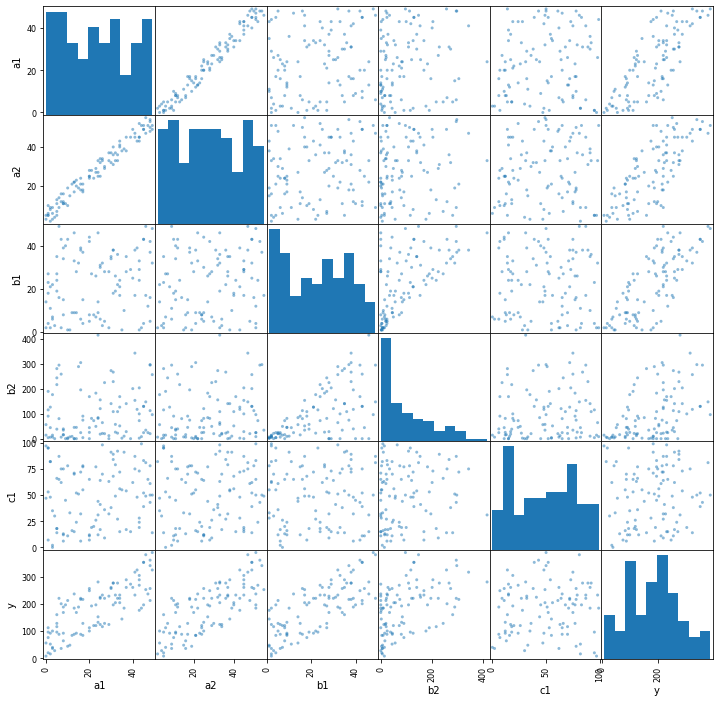

,name,mse,mean_squared_error,r2_score,intercept,coeffs_zero,zero_params,a1,a2,b1,b2,c1
0,Lasso -1e-10|False,0.00916475,0.00916475,0.999999,0.000000e+00,0,,3.97125550,0.02639463,3.99890339,0.00008360,-0.00065460
1,Lasso -0.0001|False,0.00916526,0.00916526,0.999999,0.000000e+00,0,,3.97125468,0.02639513,3.99890292,0.00008365,-0.00065440
2,Lasso -0.001|False,0.00916987,0.00916987,0.999999,0.000000e+00,0,,3.97124731,0.02639966,3.99889866,0.00008406,-0.00065255
3,Lasso -0.01|False,0.00921676,0.00921676,0.999999,0.000000e+00,0,,3.97117365,0.02644495,3.99885611,0.00008821,-0.00063414
4,Lasso -1|False,0.02168297,0.02168297,0.999997,0.000000e+00,1,c1,3.96013669,0.03541030,3.99464555,0.00061093,0.00000000
5,Lasso -5|False,0.17829248,0.17829248,0.999979,0.000000e+00,0,,3.90808735,0.08077049,3.97841945,0.00285644,0.00004465
6,Lasso -1e-10|True,0.00096488,0.00096488,1.000000,5.423752e-02,0,,4.01087551,-0.01056504,3.99974224,-0.00001316,-0.00012664
7,Lasso -0.0001|True,0.00039116,0.00039116,1.000000,3.282506e-02,1,b2,4.00689198,-0.00662303,3.99971878,-0.00000000,-0.00005225
8,Lasso -0.001|True,0.00016588,0.00016588,1.000000,2.584643e-02,3,"a2, b2, c1",3.99945692,0.00000000,3.99941267,0.00000000,0.00000000
9,Lasso -0.01|True,0.01679249,0.01679249,0.999998,2.600349e-01,3,"a2, b2, c1",3.99448546,0.00000000,3.99414356,0.00000000,0.00000000


In [6]:
pdd = gen_dataset(100)
pdres = test_batch( addy(pdd,pdd["a1"]*4+4*pdd["b1"]) )
pdres

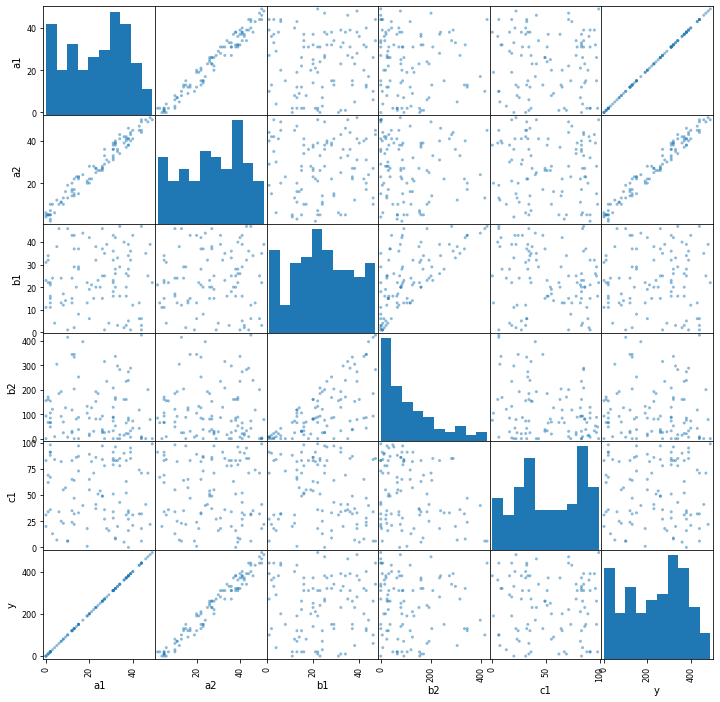

,name,mse,mean_squared_error,r2_score,intercept,coeffs_zero,zero_params,a1,a2,b1,b2,c1
0,Lasso -1e-10|False,0.00000000,0.00000000,1.000000,0.000000e+00,1,b1,10.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,Lasso -0.0001|False,0.00000000,0.00000000,1.000000,0.000000e+00,1,b1,9.99999982,0.00000002,0.00000000,0.00000001,0.00000001
2,Lasso -0.001|False,0.00000000,0.00000000,1.000000,0.000000e+00,1,b1,9.99999825,0.00000022,0.00000000,0.00000011,0.00000007
3,Lasso -0.01|False,0.00000010,0.00000010,1.000000,0.000000e+00,1,b1,9.99998246,0.00000219,0.00000000,0.00000114,0.00000066
4,Lasso -1|False,0.00101189,0.00101189,1.000000,0.000000e+00,1,b1,9.99824608,0.00021857,0.00000000,0.00011440,0.00006629
5,Lasso -5|False,0.03704415,0.03704415,0.999998,0.000000e+00,1,b1,9.98771211,0.00230798,0.00000000,0.00062195,0.00096989
6,Lasso -1e-10|True,0.00000000,0.00000000,1.000000,1.670458e-09,4,"a2, b1, b2, c1",10.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000
7,Lasso -0.0001|True,0.00000100,0.00000100,1.000000,1.670433e-03,4,"a2, b1, b2, c1",9.99992910,0.00000000,0.00000000,-0.00000000,-0.00000000
8,Lasso -0.001|True,0.00010000,0.00010000,1.000000,1.670433e-02,4,"a2, b1, b2, c1",9.99929099,0.00000000,0.00000000,-0.00000000,-0.00000000
9,Lasso -0.01|True,0.01000000,0.01000000,0.999999,1.670433e-01,4,"a2, b1, b2, c1",9.99290988,0.00000000,0.00000000,-0.00000000,-0.00000000


In [7]:
pdd = gen_dataset(100)
pdres = test_batch( addy(pdd,pdd["a1"] * 10) )
pdres

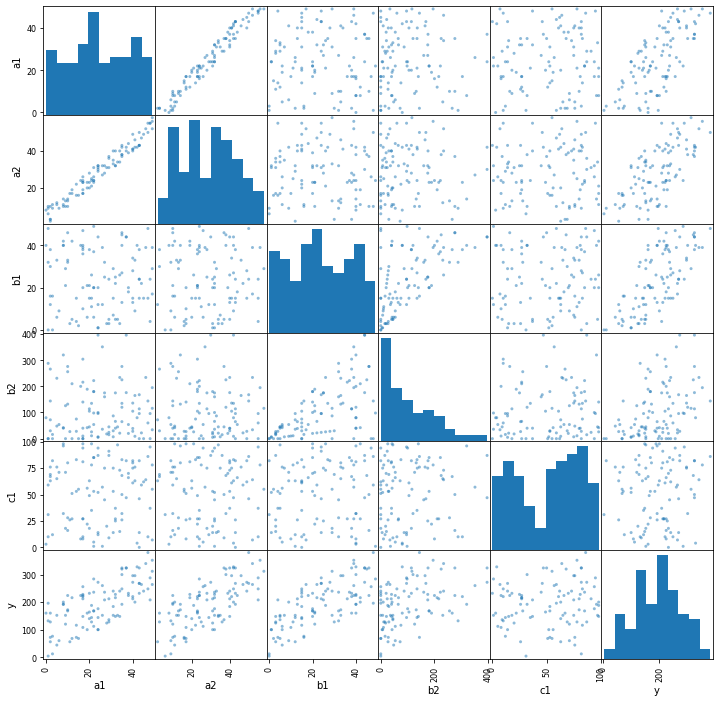

,name,mse,mean_squared_error,r2_score,intercept,coeffs_zero,zero_params,a1,a2,b1,b2,c1
0,Lasso -1e-10|False,0.01143799,0.01143799,0.999998,0.000000e+00,0,,3.96600732,0.03138827,3.99889470,-0.00005406,-0.00043215
1,Lasso -0.0001|False,0.01143858,0.01143858,0.999998,0.000000e+00,0,,3.96600642,0.03138887,3.99889401,-0.00005397,-0.00043193
2,Lasso -0.001|False,0.01144393,0.01144393,0.999998,0.000000e+00,0,,3.96599828,0.03139424,3.99888775,-0.00005323,-0.00042994
3,Lasso -0.01|False,0.01149857,0.01149857,0.999998,0.000000e+00,0,,3.96591696,0.03144798,3.99882519,-0.00004579,-0.00041004
4,Lasso -1|False,0.02496633,0.02496633,0.999996,0.000000e+00,0,,3.95345559,0.04215058,3.99457226,0.00046753,0.00000963
5,Lasso -5|False,0.18126669,0.18126669,0.999972,0.000000e+00,0,,3.90362248,0.08484240,3.97731482,0.00255560,0.00177768
6,Lasso -1e-10|True,0.00003525,0.00003525,1.000000,-6.759263e-03,0,,3.99798418,0.00196059,3.99995994,0.00000189,0.00001361
7,Lasso -0.0001|True,0.00003992,0.00003992,1.000000,-3.057539e-03,2,"b2, c1",3.99791566,0.00195704,3.99991746,0.00000000,0.00000000
8,Lasso -0.001|True,0.00026254,0.00026254,1.000000,2.776974e-02,2,"b2, c1",3.99730161,0.00192109,3.99930105,0.00000000,0.00000000
9,Lasso -0.01|True,0.02062650,0.02062650,0.999997,3.388441e-01,2,"b2, c1",3.99120023,0.00152816,3.99301859,0.00000000,0.00000000


In [8]:
pdd = gen_dataset(100)
pdres = test_batch( addy(pdd,pdd["a1"]*4+4*pdd["b1"]) )
pdres

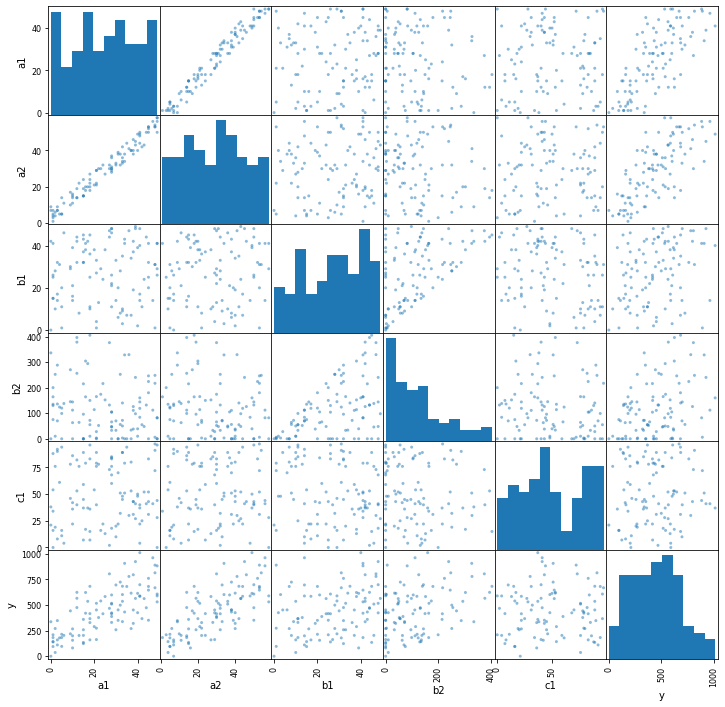

,name,mse,mean_squared_error,r2_score,intercept,coeffs_zero,zero_params,a1,a2,b1,b2,c1
0,Lasso -1e-10|False,11873.25862479,11873.25862479,0.780242,0.000000,0,,5.33324481,6.74495830,-0.64648586,1.08582448,0.13628906
1,Lasso -0.0001|False,11873.25862479,11873.25862479,0.780242,0.000000,0,,5.33325053,6.74495260,-0.64648492,1.08582442,0.13628914
2,Lasso -0.001|False,11873.25862483,11873.25862483,0.780242,0.000000,0,,5.33330244,6.74490094,-0.64647651,1.08582394,0.13628984
3,Lasso -0.01|False,11873.25862908,11873.25862908,0.780242,0.000000,0,,5.33381826,6.74438733,-0.64639244,1.08581906,0.13629675
4,Lasso -1|False,11873.29675932,11873.29675932,0.780241,0.000000,0,,5.38549697,6.69250387,-0.63720206,1.08526587,0.13696411
5,Lasso -5|False,11873.62260602,11873.62260602,0.780235,0.000000,0,,5.34337912,6.71158454,-0.60293170,1.08220145,0.13507461
6,Lasso -1e-10|True,11770.40544806,11770.40544806,0.782146,-35.730284,0,,4.71356248,7.62466095,-0.27209611,1.10414057,0.34342456
7,Lasso -0.0001|True,11770.40555259,11770.40555259,0.782146,-35.721452,0,,4.71697803,7.62140210,-0.27197040,1.10412582,0.34341983
8,Lasso -0.001|True,11770.40907727,11770.40907727,0.782146,-35.669781,0,,4.73232839,7.60632929,-0.27071925,1.10395794,0.34327400
9,Lasso -0.01|True,11770.47434398,11770.47434398,0.782144,-35.447079,0,,4.72318249,7.60627976,-0.25694122,1.10190739,0.34072464


In [9]:
pdd3 = gen_dataset(100)
pdres = test_batch( addy(pdd3,pdd3["a1"] * 14 * np.random.uniform(0.5,1.5,100)  + pdd3["b2"]) )
pdres

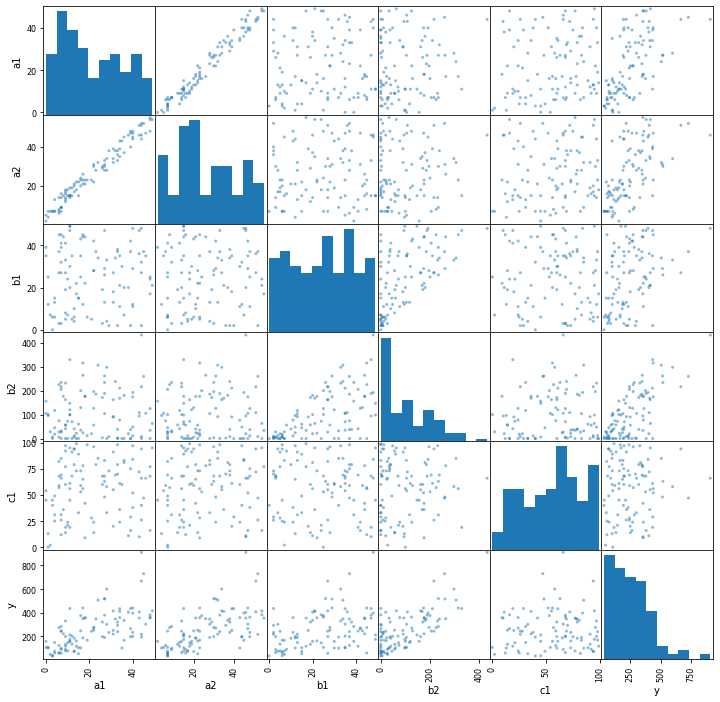

,name,mse,mean_squared_error,r2_score,intercept,coeffs_zero,zero_params,a1,a2,b1,b2,c1
0,Lasso -1e-10|False,3518.43774199,3518.43774199,0.862085,0.000000,0,,6.01830646,0.94225053,-0.59388793,1.20809485,-0.22936010
1,Lasso -0.0001|False,3518.43774199,3518.43774199,0.862085,0.000000,0,,6.01831095,0.94224580,-0.59388698,1.20809477,-0.22935987
2,Lasso -0.001|False,3518.43774202,3518.43774202,0.862085,0.000000,0,,6.01835118,0.94220334,-0.59387849,1.20809397,-0.22935777
3,Lasso -0.01|False,3518.43774540,3518.43774540,0.862085,0.000000,0,,6.01875215,0.94178005,-0.59379359,1.20808598,-0.22933682
4,Lasso -1|False,3518.46662910,3518.46662910,0.862084,0.000000,0,,6.05578974,0.90169563,-0.58475426,1.20721375,-0.22718991
5,Lasso -5|False,3518.84961389,3518.84961389,0.862069,0.000000,0,,6.05456579,0.87796755,-0.55461248,1.20382044,-0.22188646
6,Lasso -1e-10|True,3415.02051871,3415.02051871,0.866139,36.824263,0,,7.67310975,-0.92449800,-0.95370292,1.21312905,-0.44342845
7,Lasso -0.0001|True,3415.02064233,3415.02064233,0.866139,36.801692,0,,7.66911047,-0.92061903,-0.95349480,1.21310215,-0.44335735
8,Lasso -0.001|True,3415.03287906,3415.03287906,0.866138,36.598569,0,,7.63311991,-0.88571108,-0.95162182,1.21286005,-0.44271743
9,Lasso -0.01|True,3416.25162390,3416.25162390,0.866090,34.570952,0,,7.27405851,-0.53743785,-0.93289862,1.21043906,-0.43632481


In [10]:
pdd3 = gen_dataset(100)
pdres = test_batch( addy(pdd3,pdd3["a1"] * 14 * np.random.uniform(0.2,0.8,100)  + pdd3["b2"]) )
pdres